# CZ4041 Group 28 Notebook 4
## UNet Segmentation with ResNet18 Encoder

- **Overview**    
This kernel uses a UNet model with a resnet18 encoder pretrained on imagenet for this challenge.    
       
       
- **Loss**     
The loss used for this model is BinaryCrossEntropy with logits (otherwise known as BCE loss). Metrics like Dice and IoU are also used to measure the model's validation performance.
      
      
- **Augmentations**     
We have tested several augmentations using the albumentations library as mentioned in the report and presentation video. However, the vanilla version with simple horizontal flip and normalization is still the top-performing one at `0.88536` on the private leaderboard.

## Imports

In [1]:
!pip install torchviz
import sys
import functools
import os
import pdb
import random
import time
import warnings

import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.model_zoo as model_zoo
from albumentations import (Compose, GaussNoise, HorizontalFlip, Normalize,
                            Resize, ShiftScaleRotate)
from albumentations.pytorch import ToTensor
from pretrainedmodels.models.torchvision_models import pretrained_settings
from torch.nn import functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, sampler
from torchvision.models.resnet import BasicBlock, Bottleneck, ResNet

warnings.filterwarnings("ignore")
seed = 69
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

     |████████████████████████████████| 51kB 2.4MB/s 
  Created wheel for torchviz: filename=torchviz-0.0.1-cp36-none-any.whl size=3520 sha256=74ca1dd12fe6be3526255bbde69d985f4f54a53762672b77c5487db281a19d96
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [ ]:
ENCODER_NAME = "resnet18"
BATCH_SIZE = 16

## Unet Building Blocks & Architecture

In [2]:
def preprocess_input(x, mean=None, std=None, input_space='RGB', input_range=None, **kwargs):

    if input_space == 'BGR':
        x = x[..., ::-1].copy()

    if input_range is not None:
        if x.max() > 1 and input_range[1] == 1:
            x = x / 255.

    if mean is not None:
        mean = np.array(mean)
        x = x - mean

    if std is not None:
        std = np.array(std)
        x = x / std

    return x


class Model(nn.Module):

    def __init__(self):
        super().__init__()

    def initialize(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


class Conv2dReLU(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0,
                 stride=1, use_batchnorm=True, **batchnorm_params):

        super().__init__()

        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size,
                              stride=stride, padding=padding, bias=not (use_batchnorm)),
            nn.ReLU(inplace=True),
        ]

        if use_batchnorm:
            layers.insert(1, nn.BatchNorm2d(out_channels, **batchnorm_params))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)


class EncoderDecoder(Model):

    def __init__(self, encoder, decoder, activation):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        if callable(activation) or activation is None:
            self.activation = activation
        elif activation == 'softmax':
            self.activation = nn.Softmax(dim=1)
        elif activation == 'sigmoid':
            self.activation = nn.Sigmoid()
        else:
            raise ValueError('Activation should be "sigmoid"/"softmax"/callable/None')

    def forward(self, x):
        """Sequentially pass `x` trough model`s `encoder` and `decoder` (return logits!)"""
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    def predict(self, x):
        """Inference method. Switch model to `eval` mode, call `.forward(x)`
        and apply activation function (if activation is not `None`) with `torch.no_grad()`

        Args:
            x: 4D torch tensor with shape (batch_size, channels, height, width)

        Return:
            prediction: 4D torch tensor with shape (batch_size, classes, height, width)

        """
        if self.training:
            self.eval()

        with torch.no_grad():
            x = self.forward(x)
            if self.activation:
                x = self.activation(x)

        return x


class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            Conv2dReLU(in_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
            Conv2dReLU(out_channels, out_channels, kernel_size=3, padding=1, use_batchnorm=use_batchnorm),
        )

    def forward(self, x):
        x, skip = x
        x = F.interpolate(x, scale_factor=2, mode='nearest')
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x


class CenterBlock(DecoderBlock):

    def forward(self, x):
        return self.block(x)


class UnetDecoder(Model):

    def __init__(
            self,
            encoder_channels,
            decoder_channels=(256, 128, 64, 32, 16),
            final_channels=1,
            use_batchnorm=True,
            center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = CenterBlock(channels, channels, use_batchnorm=use_batchnorm)
        else:
            self.center = None

        in_channels = self.compute_channels(encoder_channels, decoder_channels)
        out_channels = decoder_channels

        self.layer1 = DecoderBlock(in_channels[0], out_channels[0], use_batchnorm=use_batchnorm)
        self.layer2 = DecoderBlock(in_channels[1], out_channels[1], use_batchnorm=use_batchnorm)
        self.layer3 = DecoderBlock(in_channels[2], out_channels[2], use_batchnorm=use_batchnorm)
        self.layer4 = DecoderBlock(in_channels[3], out_channels[3], use_batchnorm=use_batchnorm)
        self.layer5 = DecoderBlock(in_channels[4], out_channels[4], use_batchnorm=use_batchnorm)
        self.final_conv = nn.Conv2d(out_channels[4], final_channels, kernel_size=(1, 1))

        self.initialize()

    def compute_channels(self, encoder_channels, decoder_channels):
        channels = [
            encoder_channels[0] + encoder_channels[1],
            encoder_channels[2] + decoder_channels[0],
            encoder_channels[3] + decoder_channels[1],
            encoder_channels[4] + decoder_channels[2],
            0 + decoder_channels[3],
        ]
        return channels

    def forward(self, x):
        encoder_head = x[0]
        skips = x[1:]

        if self.center:
            encoder_head = self.center(encoder_head)

        x = self.layer1([encoder_head, skips[0]])
        x = self.layer2([x, skips[1]])
        x = self.layer3([x, skips[2]])
        x = self.layer4([x, skips[3]])
        x = self.layer5([x, None])
        x = self.final_conv(x)

        return x


class ResNetEncoder(ResNet):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pretrained = False
        del self.fc

    def forward(self, x):
        x0 = self.conv1(x)
        x0 = self.bn1(x0)
        x0 = self.relu(x0)

        x1 = self.maxpool(x0)
        x1 = self.layer1(x1)

        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        return [x4, x3, x2, x1, x0]

    def load_state_dict(self, state_dict, **kwargs):
        state_dict.pop('fc.bias')
        state_dict.pop('fc.weight')
        super().load_state_dict(state_dict, **kwargs)

# ImageNet Pretrained weights
url = {
    'resnet18': "https://data.lip6.fr/cadene/pretrainedmodels/resnet18-5c106cde.pth",
    'resnet34': "https://data.lip6.fr/cadene/pretrainedmodels/resnet34-333f7ec4.pth",
    'resnet50': "https://data.lip6.fr/cadene/pretrainedmodels/resnet50-19c8e357.pth",
    'resnet101': "https://data.lip6.fr/cadene/pretrainedmodels/resnet101-5d3b4d8f.pth",
    'resnet152': "https://data.lip6.fr/cadene/pretrainedmodels/resnet152-b121ed2d.pth",
}
        
resnet_encoders = {
    'resnet18': {
        'url' : url["resnet18"],
        'encoder': ResNetEncoder,
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [2, 2, 2, 2],
        },
    },

    'resnet34': {
        'url' : url["resnet34"],
        'encoder': ResNetEncoder,
        'out_shapes': (512, 256, 128, 64, 64),
        'params': {
            'block': BasicBlock,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet50': {
        'url' : url["resnet50"],
        'encoder': ResNetEncoder,
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 6, 3],
        },
    },

    'resnet101': {
        'url' : url["resnet101"],
        'encoder': ResNetEncoder,
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 4, 23, 3],
        },
    },

    'resnet152': {
        'url' : url["resnet152"],
        'encoder': ResNetEncoder,
        'out_shapes': (2048, 1024, 512, 256, 64),
        'params': {
            'block': Bottleneck,
            'layers': [3, 8, 36, 3],
        },
    },
}

encoders = {}
encoders.update(resnet_encoders)

def get_encoder(name, encoder_weights=None):
    Encoder = encoders[name]['encoder']
    encoder = Encoder(**encoders[name]['params'])
    encoder.out_shapes = encoders[name]['out_shapes']

    if encoder_weights is not None:
        settings = encoders[name]
        encoder.load_state_dict(model_zoo.load_url(settings['url']))

    return encoder


def get_encoder_names():
    return list(encoders.keys())


def get_preprocessing_fn(encoder_name, pretrained='imagenet'):
    settings = encoders[encoder_name]['pretrained_settings']

    if pretrained not in settings.keys():
        raise ValueError('Avaliable pretrained options {}'.format(settings.keys()))

    input_space = settings[pretrained].get('input_space')
    input_range = settings[pretrained].get('input_range')
    mean = settings[pretrained].get('mean')
    std = settings[pretrained].get('std')
    
    return functools.partial(preprocess_input, mean=mean, std=std, input_space=input_space, input_range=input_range)


class Unet(EncoderDecoder):
    """Unet_ is a fully convolution neural network for image semantic segmentation

    Args:
        encoder_name: name of classification model (without last dense layers) used as feature
            extractor to build segmentation model.
        encoder_weights: one of ``None`` (random initialization), ``imagenet`` (pre-training on ImageNet).
        decoder_channels: list of numbers of ``Conv2D`` layer filters in decoder blocks
        decoder_use_batchnorm: if ``True``, ``BatchNormalisation`` layer between ``Conv2D`` and ``Activation`` layers
            is used.
        classes: a number of classes for output (output shape - ``(batch, classes, h, w)``).
        activation: activation function used in ``.predict(x)`` method for inference.
            One of [``sigmoid``, ``softmax``, callable, None]
        center: if ``True`` add ``Conv2dReLU`` block on encoder head (useful for VGG models)

    Returns:
        ``torch.nn.Module``: **Unet**

    .. _Unet:
        https://arxiv.org/pdf/1505.04597

    """

    def __init__(
            self,
            encoder_name='resnet34',
            encoder_weights='imagenet',
            decoder_use_batchnorm=True,
            decoder_channels=(256, 128, 64, 32, 16),
            classes=1,
            activation='sigmoid',
            center=False,  # usefull for VGG models
    ):
        encoder = get_encoder(
            encoder_name,
            encoder_weights=encoder_weights
        )

        decoder = UnetDecoder(
            encoder_channels=encoder.out_shapes,
            decoder_channels=decoder_channels,
            final_channels=classes,
            use_batchnorm=decoder_use_batchnorm,
            center=center,
        )

        super().__init__(encoder, decoder, activation)

        self.name = 'u-{}'.format(encoder_name)

## RLE-Mask Utility Functions

In [3]:
def mask2rle(img):
    '''
    img: numpy array, 1 -> mask, 0 -> background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def make_mask(row_id, df):
    '''Given a row index, return image_id and mask (256, 1600, 4) from the dataframe `df`'''
    fname = df.iloc[row_id].name
    labels = df.iloc[row_id][:4]
    masks = np.zeros((256, 1600, 4), dtype=np.float32) # float32 is V.Imp
    # 4:class 1～4 (ch:0～3)

    for idx, label in enumerate(labels.values):
        if label is not np.nan:
            label = label.split(" ")
            positions = map(int, label[0::2])
            length = map(int, label[1::2])
            mask = np.zeros(256 * 1600, dtype=np.uint8)
            for pos, le in zip(positions, length):
                mask[pos:(pos + le)] = 1
            masks[:, :, idx] = mask.reshape(256, 1600, order='F')
    return fname, masks

## Dataloader with Augmentations

In [4]:
class SteelDataset(Dataset):
    def __init__(self, df, data_folder, mean, std, phase):
        self.df = df
        self.root = data_folder
        self.mean = mean
        self.std = std
        self.phase = phase
        self.transforms = get_transforms(phase, mean, std)
        self.fnames = self.df.index.tolist()

    def __getitem__(self, idx):
        image_id, mask = make_mask(idx, self.df)
        image_path = os.path.join(self.root, "train_images",  image_id)
        img = cv2.imread(image_path)
        augmented = self.transforms(image=img, mask=mask)
        img = augmented['image']
        mask = augmented['mask'] # 1x256x1600x4
        mask = mask[0].permute(2, 0, 1) # 4x256x1600
        return img, mask

    def __len__(self):
        return len(self.fnames)


def get_transforms(phase, mean, std):
    list_transforms = []
    if phase == "train":
        list_transforms.extend(
            [
                HorizontalFlip(p=0.5),
            ]
        )
    list_transforms.extend(
        [
            Normalize(mean=mean, std=std, p=1),
            ToTensor(),
        ]
    )
    list_trfms = Compose(list_transforms)
    return list_trfms

def provider(
    data_folder,
    df_path,
    phase,
    mean=None,
    std=None,
    batch_size=BATCH_SIZE*2,
    num_workers=4,
):
    '''Returns dataloader for the model training'''
    df = pd.read_csv(df_path)
    # https://www.kaggle.com/amanooo/defect-detection-starter-u-net
    df['ClassId'] = df['ClassId'].astype(int)
    df = df.pivot(index='ImageId',columns='ClassId',values='EncodedPixels')
    df['defects'] = df.count(axis=1)
    
    train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["defects"], random_state=69)
    df = train_df if phase == "train" else val_df
    image_dataset = SteelDataset(df, data_folder, mean, std, phase)
    dataloader = DataLoader(
        image_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=True,
        shuffle=True,   
    )

    return dataloader


## Some More Utility Functions

Dice and IoU Metric Implementations, Metric Logger for Training and Validation.

In [5]:
def predict(X, threshold):
    '''X is sigmoid output of the model'''
    X_p = np.copy(X)
    preds = (X_p > threshold).astype('uint8')
    return preds

def metric(probability, truth, threshold=0.5, reduction='none'):
    '''Calculates dice of positive and negative images seperately'''
    '''probability and truth must be torch tensors'''
    batch_size = len(truth)
    with torch.no_grad():
        probability = probability.view(batch_size, -1)
        truth = truth.view(batch_size, -1)
        assert(probability.shape == truth.shape)

        p = (probability > threshold).float()
        t = (truth > 0.5).float()

        t_sum = t.sum(-1)
        p_sum = p.sum(-1)
        neg_index = torch.nonzero(t_sum == 0)
        pos_index = torch.nonzero(t_sum >= 1)

        dice_neg = (p_sum == 0).float()
        dice_pos = 2 * (p*t).sum(-1)/((p+t).sum(-1))

        dice_neg = dice_neg[neg_index]
        dice_pos = dice_pos[pos_index]
        dice = torch.cat([dice_pos, dice_neg])

        num_neg = len(neg_index)
        num_pos = len(pos_index)

    return dice, dice_neg, dice_pos, num_neg, num_pos

class Meter:
    '''A meter to keep track of iou and dice scores throughout an epoch'''
    def __init__(self, phase, epoch):
        self.base_threshold = 0.5 # <<<<<<<<<<< here's the threshold
        self.base_dice_scores = []
        self.dice_neg_scores = []
        self.dice_pos_scores = []
        self.iou_scores = []

    def update(self, targets, outputs):
        probs = torch.sigmoid(outputs)
        dice, dice_neg, dice_pos, _, _ = metric(probs, targets, self.base_threshold)
        self.base_dice_scores.extend(dice.tolist())
        self.dice_pos_scores.extend(dice_pos.tolist())
        self.dice_neg_scores.extend(dice_neg.tolist())
        preds = predict(probs, self.base_threshold)
        iou = compute_iou_batch(preds, targets, classes=[1])
        self.iou_scores.append(iou)

    def get_metrics(self):
        dice = np.nanmean(self.base_dice_scores)
        dice_neg = np.nanmean(self.dice_neg_scores)
        dice_pos = np.nanmean(self.dice_pos_scores)
        dices = [dice, dice_neg, dice_pos]
        iou = np.nanmean(self.iou_scores)
        return dices, iou

def epoch_log(phase, epoch, epoch_loss, meter, start):
    '''logging the metrics at the end of an epoch'''
    dices, iou = meter.get_metrics()
    dice, dice_neg, dice_pos = dices
    print("Loss: %0.4f | IoU: %0.4f | dice: %0.4f | dice_neg: %0.4f | dice_pos: %0.4f" % (epoch_loss, iou, dice, dice_neg, dice_pos))
    return dice, iou

def compute_ious(pred, label, classes, ignore_index=255, only_present=True):
    '''computes iou for one ground truth mask and predicted mask'''
    pred[label == ignore_index] = 0
    ious = []
    for c in classes:
        label_c = label == c
        if only_present and np.sum(label_c) == 0:
            ious.append(np.nan)
            continue
        pred_c = pred == c
        intersection = np.logical_and(pred_c, label_c).sum()
        union = np.logical_or(pred_c, label_c).sum()
        if union != 0:
            ious.append(intersection / union)
    return ious if ious else [1]

def compute_iou_batch(outputs, labels, classes=None):
    '''computes mean iou for a batch of ground truth masks and predicted masks'''
    ious = []
    preds = np.copy(outputs) # copy is imp
    labels = np.array(labels) # tensor to np
    for pred, label in zip(preds, labels):
        ious.append(np.nanmean(compute_ious(pred, label, classes)))
    iou = np.nanmean(ious)
    return iou


## Model Initialization

In [7]:
model = Unet(ENCODER_NAME, encoder_weights="imagenet", classes=4, activation=None)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s] 


In [8]:
model 

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [9]:
from torchviz import make_dot
from torch.autograd import Variable
inputs = torch.randn(1,3,224,224)
y = model(Variable(inputs))
g = make_dot(y.mean(), params=dict(model.named_parameters()))

g.format = 'svg'
g.render(filename='Unet_visualization')

'Unet_visualization.svg'

## Training & Validation

- BCE with Logits loss is used as Dice Loss would not be differentiable unless the sigmoid function is removed.         
This version of Dice Loss would also be make the training unstable, and hence we will be unable to discern model performance.

In [10]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model):
        self.num_workers = 6
        self.batch_size = {"train": BATCH_SIZE, "val": BATCH_SIZE}
        self.accumulation_steps = 32 // self.batch_size['train']
        self.lr = 5e-4
        self.num_epochs = 20
        self.best_loss = float("inf")
        self.phases = ["train", "val"]
        self.device = torch.device("cuda:0")
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        self.net = model
        self.criterion = torch.nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        self.net = self.net.to(self.device)
        cudnn.benchmark = True
        self.dataloaders = {
            phase: provider(
                data_folder=data_folder,
                df_path=train_df_path,
                phase=phase,
                mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225),
                batch_size=self.batch_size[phase],
                num_workers=self.num_workers,
            )
            for phase in self.phases
        }
        self.losses = {phase: [] for phase in self.phases}
        self.iou_scores = {phase: [] for phase in self.phases}
        self.dice_scores = {phase: [] for phase in self.phases}
        
    def forward(self, images, targets):
        images = images.to(self.device)
        masks = targets.to(self.device)
        outputs = self.net(images)
        loss = self.criterion(outputs, masks)
        return loss, outputs

    def iterate(self, epoch, phase):
        meter = Meter(phase, epoch)
        start = time.strftime("%H:%M:%S")
        print(f"Starting epoch: {epoch} | phase: {phase} | ⏰: {start}")
        batch_size = self.batch_size[phase]
        self.net.train(phase == "train")
        dataloader = self.dataloaders[phase]
        running_loss = 0.0
        total_batches = len(dataloader)
        self.optimizer.zero_grad()
        for itr, batch in enumerate(dataloader): # replace `dataloader` with `tk0` for tqdm
            images, targets = batch
            loss, outputs = self.forward(images, targets)
            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()
            running_loss += loss.item()
            outputs = outputs.detach().cpu()
            meter.update(targets, outputs)
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        dice, iou = epoch_log(phase, epoch, epoch_loss, meter, start)
        self.losses[phase].append(epoch_loss)
        self.dice_scores[phase].append(dice)
        self.iou_scores[phase].append(iou)
        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.net.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }
            with torch.no_grad():
                val_loss = self.iterate(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = val_loss
                torch.save(state, "./model.pth")
            print()


In [11]:
sample_submission_path = '../input/severstal-steel-defect-detection/sample_submission.csv'
train_df_path = '../input/severstal-steel-defect-detection/train.csv'
data_folder = "../input/severstal-steel-defect-detection/"
test_data_folder = "../input/severstal-steel-defect-detection/test_images"

In [12]:
model_trainer = Trainer(model)
model_trainer.start()

Starting epoch: 0 | phase: train | ⏰: 08:40:55
Loss: 0.3156 | IoU: 0.1741 | dice: 0.2584 | dice_neg: nan | dice_pos: 0.2584
Starting epoch: 0 | phase: val | ⏰: 08:50:32
Loss: 0.2030 | IoU: 0.3404 | dice: 0.4582 | dice_neg: nan | dice_pos: 0.4582
******** New optimal found, saving state ********

Starting epoch: 1 | phase: train | ⏰: 08:52:28
Loss: 0.1569 | IoU: 0.3322 | dice: 0.4472 | dice_neg: nan | dice_pos: 0.4472
Starting epoch: 1 | phase: val | ⏰: 09:02:01
Loss: 0.1161 | IoU: 0.3837 | dice: 0.4960 | dice_neg: nan | dice_pos: 0.4960
******** New optimal found, saving state ********

Starting epoch: 2 | phase: train | ⏰: 09:03:51
Loss: 0.0914 | IoU: 0.3911 | dice: 0.5025 | dice_neg: nan | dice_pos: 0.5025
Starting epoch: 2 | phase: val | ⏰: 09:13:36
Loss: 0.0714 | IoU: 0.4050 | dice: 0.5107 | dice_neg: nan | dice_pos: 0.5107
******** New optimal found, saving state ********

Starting epoch: 3 | phase: train | ⏰: 09:15:29
Loss: 0.0622 | IoU: 0.4060 | dice: 0.5160 | dice_neg: nan | di

## Metric History 

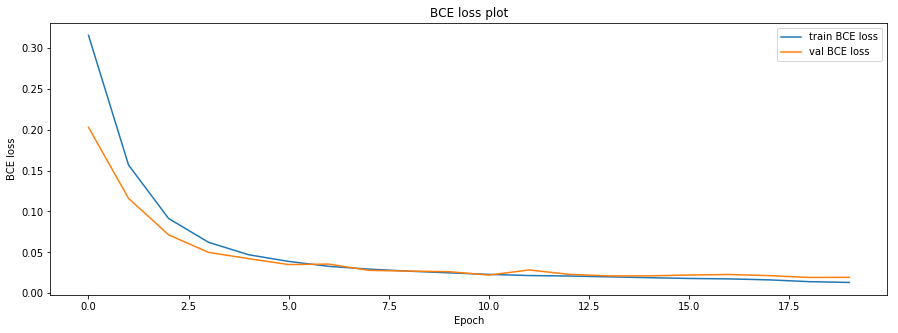

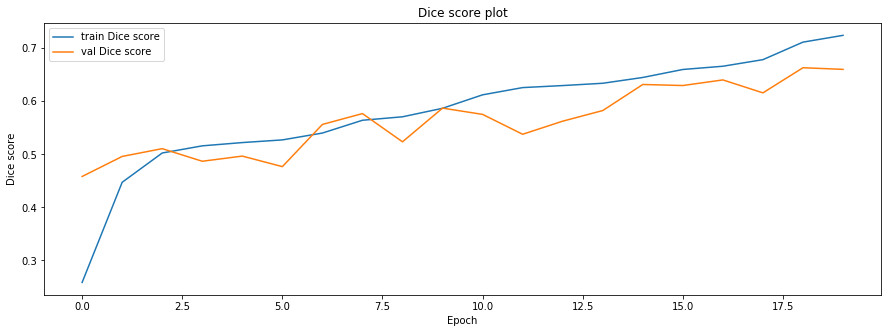

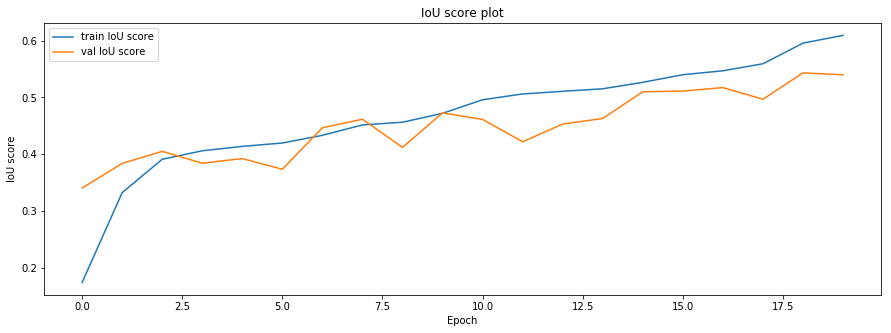

In [13]:
losses = model_trainer.losses
dice_scores = model_trainer.dice_scores # overall dice
iou_scores = model_trainer.iou_scores

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["val"], label=f'val {name}')
    plt.title(f'{name} plot'); plt.xlabel('Epoch'); plt.ylabel(f'{name}');
    plt.legend(); 
    plt.show()

plot(losses, "BCE loss")
plot(dice_scores, "Dice score")
plot(iou_scores, "IoU score")

## Test Prediction and Submission

In [14]:
class TestDataset(Dataset):
    '''Dataset for test prediction'''
    def __init__(self, root, df, mean, std):
        self.root = root
        self.fnames = df['ImageId'].unique().tolist()
        self.num_samples = len(self.fnames)
        self.transform = Compose(
            [
                Normalize(mean=mean, std=std, p=1),
                ToTensor(),
            ]
        )

    def __getitem__(self, idx):
        fname = self.fnames[idx]
        path = os.path.join(self.root, fname)
        image = cv2.imread(path)
        images = self.transform(image=image)["image"]
        return fname, images

    def __len__(self):
        return self.num_samples

In [15]:
def post_process(probability, threshold, min_size):
    '''Post processing of each predicted mask, components with lesser number of pixels
    than `min_size` are ignored'''
    mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
    num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
    predictions = np.zeros((256, 1600), np.float32)
    num = 0
    for c in range(1, num_component):
        p = (component == c)
        if p.sum() > min_size:
            predictions[p] = 1
            num += 1
    return predictions, num

In [16]:
# Initialize Test Dataloader
best_threshold = 0.5
num_workers = 2
batch_size = 4
print('best_threshold', best_threshold)
min_size = 3500
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
df = pd.read_csv(sample_submission_path)
testset = DataLoader(
    TestDataset(test_data_folder, df, mean, std),
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

best_threshold 0.5


In [17]:
# Initialize Mode and load Trained Weights
ckpt_path = "./model.pth"
device = torch.device("cuda")
model = Unet(ENCODER_NAME, encoder_weights=None, classes=4, activation=None)
model.to(device)
model.eval()
state = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(state["state_dict"])

<All keys matched successfully>

In [18]:
# Start Prediction
predictions = []
for i, batch in enumerate(tqdm(testset)):
    fnames, images = batch
    batch_preds = torch.sigmoid(model(images.to(device)))
    batch_preds = batch_preds.detach().cpu().numpy()
    for fname, preds in zip(fnames, batch_preds):
        for cls, pred in enumerate(preds):
            pred, num = post_process(pred, best_threshold, min_size)
            rle = mask2rle(pred)
            name = fname + f"_{cls+1}"
            predictions.append([name, rle])

# save predictions to submission.csv
df = pd.DataFrame(predictions, columns=['ImageId_ClassId', 'EncodedPixels'])
df = df.fillna('')
df.to_csv("./submission.csv", index=False)

In [19]:
print(df.shape)
display(df.head())

(22024, 2)


,ImageId_ClassId,EncodedPixels
0,0000f269f.jpg_1,
1,0000f269f.jpg_2,
2,0000f269f.jpg_3,146414 15 146439 2 146442 2 146446 2 146482 5 ...
3,0000f269f.jpg_4,
4,000ccc2ac.jpg_1,


## References:

* https://www.kaggle.com/paulorzp/rle-functions-run-lenght-encode-decode
* https://www.kaggle.com/amanooo/defect-detection-starter-u-net
* https://www.kaggle.com/go1dfish/clear-mask-visualization-and-simple-eda
